# 1. Setup and Data Loading
First, we check for GPU availability to ensure fast training. Then, we load the **Kuzushiji-MNIST (KMNIST)** dataset using `tensorflow_datasets`.
 KMNIST consists of ancient Japanese cursive calligraphy.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Hardware Accelerator Active: {gpus[0].name}")
else:
    print("ARNING: CPU mode detected.")

# Load KMNIST
print("Downloading KMNIST via TensorFlow Datasets...")
try:
    train_data = tfds.load('kmnist', split='train', batch_size=-1, as_supervised=True)
    test_data = tfds.load('kmnist', split='test', batch_size=-1, as_supervised=True)
    train_images, train_labels = tfds.as_numpy(train_data)
    test_images, test_labels = tfds.as_numpy(test_data)
    print(f"Dataset Loaded Successfully.")
except Exception as e:
    print(f"Error loading TFDS: {e}")

# Preprocessing
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0
print(f"Training samples: {train_images.shape[0]}")

Hardware Accelerator Active: /physical_device:GPU:0
Dataset Loaded Successfully.
Training samples: 60000


# 2. Defining the Encoder and Decoder
The core of a VAE is the **Reparameterization Trick**. Instead of mapping an image to a fixed point in the latent space, we map it to a **Probability Distribution** (defined by a Mean and a Variance).

We sample from this distribution to generate the latent vector $z$. This makes the latent space continuous and allows for smooth interpolation.

In [2]:
LATENT_DIMENSIONS = 2

class LatentSampler(layers.Layer):
    """
    Uses (mean, log_variance) to sample z.
    Formula: z = mean + sigma * epsilon
    """
    def call(self, inputs):
        mean, log_variance = inputs
        batch_size = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, dim))
        return mean + tf.exp(0.5 * log_variance) * epsilon

# Encoder
encoder_input = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(LATENT_DIMENSIONS, name="latent_mean")(x)
z_log_var = layers.Dense(LATENT_DIMENSIONS, name="latent_log_var")(x)
z_sample = LatentSampler()([z_mean, z_log_var])
encoder = keras.Model(encoder_input, [z_mean, z_log_var, z_sample], name="encoder")

# Decoder
latent_input = keras.Input(shape=(LATENT_DIMENSIONS,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_input)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_input, decoder_output, name="decoder")

# 3. The Disentangled $\beta$-VAE Logic
Here we override the standard `train_step` to implement the custom loss function.

We introduce `kl_weight` (Beta). By setting this $>1.0$, we force the model to prioritize a structured latent space over perfect reconstruction. This encourages **disentanglement**, where different features of the calligraphy are separated.

In [3]:
class DisentangledVAE(keras.Model):
    def __init__(self, encoder, decoder, kl_weight=1.0, **kwargs):
        super(DisentangledVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = recon_loss + (self.kl_weight * kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# 4. Training
We train with `kl_weight=4.0` for 25 epochs. This aggressive weighting ensures clean separation of clusters.

In [4]:
vae_model = DisentangledVAE(encoder, decoder, kl_weight=4.0)
print("Starting Training on Calligraphy Data...")
vae_model.compile(optimizer=keras.optimizers.Adam())
vae_model.fit(train_images, epochs=25, batch_size=128)

Starting Training on Calligraphy Data...
Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - kl_loss: 0.9199 - loss: 374.4893 - reconstruction_loss: 370.8095
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 3.3234 - loss: 309.1989 - reconstruction_loss: 295.9053
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 3.7365 - loss: 300.6767 - reconstruction_loss: 285.7307
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 3.8706 - loss: 297.4170 - reconstruction_loss: 281.9344
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 3.9471 - loss: 294.8704 - reconstruction_loss: 279.0821
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 3.9818 - loss: 293.2749 - reconstruction_loss: 277.3476
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 4.0223 - loss: 292.9962 - reconstruction_loss: 276.9073
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 4.0726 - loss: 291.0560 - reconstruction_loss: 274.7654
Epoch

# 5. Visualizations
Below, we visualize:
1.  **The Latent Manifold:** Showing how characters cluster by type.
2.  **Latent Morphing:** Interpolating between two characters to prove the model has learned the stroke geometry.

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


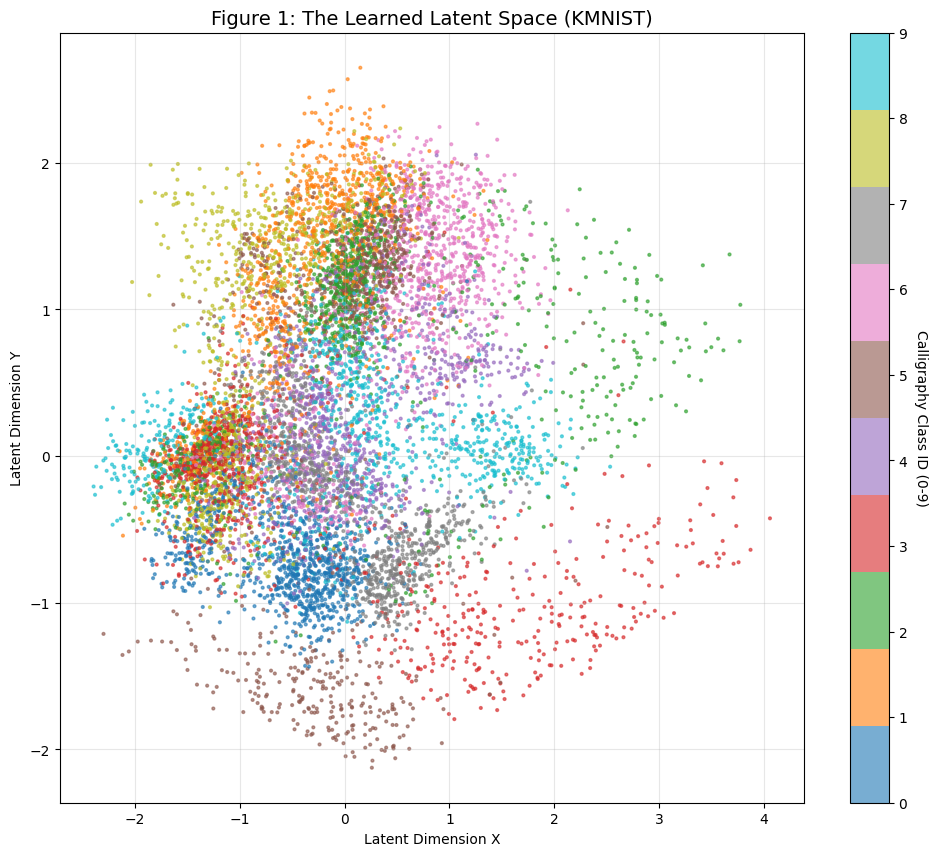

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


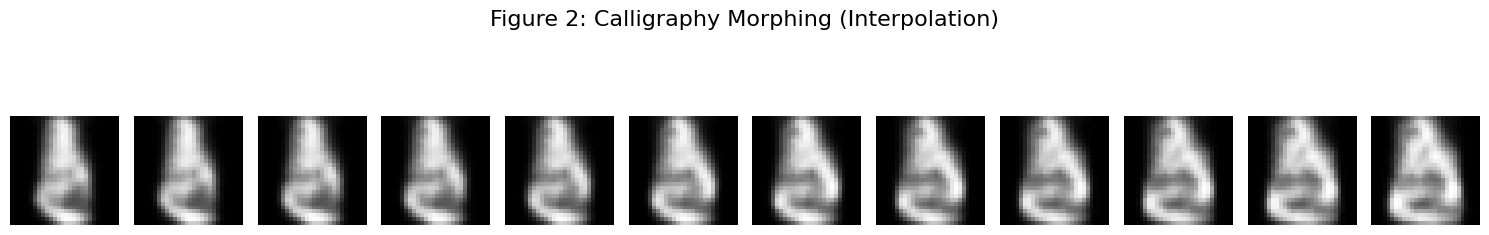

In [5]:
def visualize_latent_clusters(model, data, labels):
    z_mean, _, _ = model.encoder.predict(data, batch_size=128)
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='tab10', alpha=0.6, s=4)
    cbar = plt.colorbar(scatter)
    cbar.set_label("Calligraphy Class ID (0-9)", rotation=270, labelpad=15)
    plt.title("Figure 1: The Learned Latent Space (KMNIST)", fontsize=14)
    plt.xlabel("Latent Dimension X")
    plt.ylabel("Latent Dimension Y")
    plt.grid(True, alpha=0.3)
    plt.show()

def visualize_morphing(model, data, labels):
    z_mean, _, _ = model.encoder.predict(data, batch_size=128)
    vector_a = np.mean(z_mean[labels == 1], axis=0)
    vector_b = np.mean(z_mean[labels == 8], axis=0)
    steps = 12
    fig, axes = plt.subplots(1, steps, figsize=(15, 3))
    plt.suptitle("Figure 2: Calligraphy Morphing (Interpolation)", fontsize=16)
    for i, alpha in enumerate(np.linspace(0, 1, steps)):
        interpolated_vector = (1 - alpha) * vector_a + alpha * vector_b
        decoded_img = model.decoder.predict(interpolated_vector.reshape(1, 2), verbose=0)
        axes[i].imshow(decoded_img[0].reshape(28, 28), cmap='Greys_r')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_latent_clusters(vae_model, test_images, test_labels)
visualize_morphing(vae_model, test_images, test_labels)